**Support Vector Machine (SVM)**

I used the MNIST training dataset to select examples corresponding to the digits ‘7’ and ‘9’ and trained two binary SVM classifiers: one with a linear kernel and one with a nonlinear Gaussian (RBF) kernel. I performed hyperparameter tuning, optimizing parameters such as C and gamma to achieve the best possible classification performance.

After training, I evaluated the classifiers on the held-out test data and reported the best achieved classification accuracy for both models. Additionally, I compared the performance and computational efficiency of the scikit-learn SVM implementation with the provided PGD-based SVM optimizer, assessing both accuracy and running speed.

PGD Linear SVM: train accuracy = 93.63%, test accuracy = 92.59%, running time = 0.02s
Hyperperameters: C = 0.45, learning rate = 0.1, max epochs = 10 

PGD RBF SVM: train accuracy = 100.00%, test accuracy = 99.07%, running time = 0.31s
Hyperperameters: C = 2, gamma = 0.05, learning rate = 1.0, max epochs = 20 

sklearn Linear SVM: train accuracy = 100.00%, test accuracy = 99.07%, running time = 0.02s

sklearn RBF SVM: train accuracy = 100.00%, test accuracy = 99.07%, running time = 0.04s



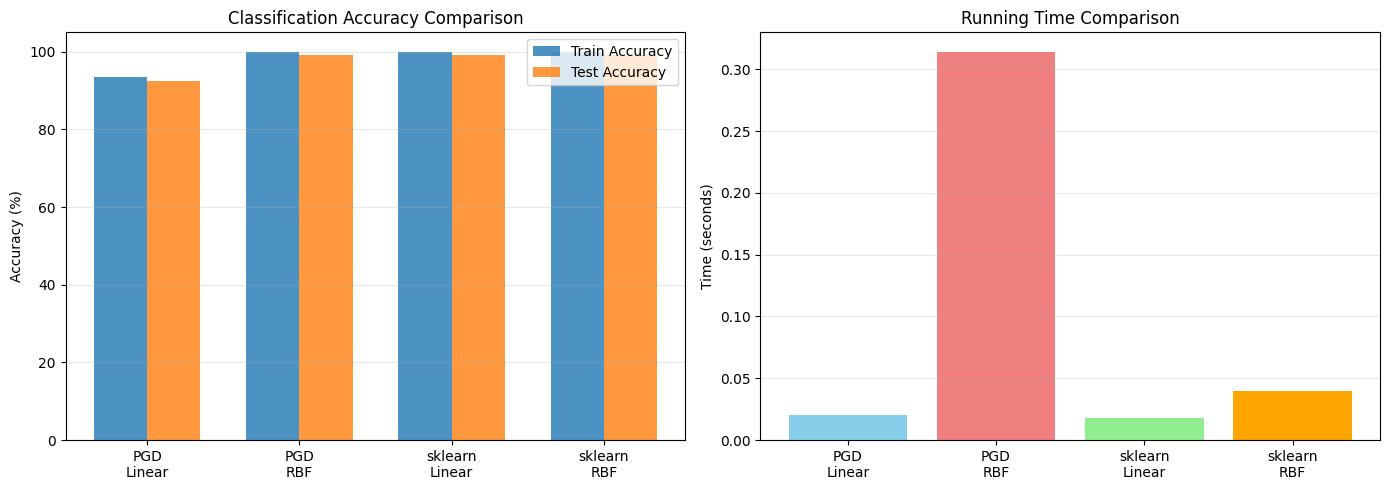

In [8]:
import numpy as np
import time
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load data (Digits 7 vs 9)
digits = datasets.load_digits()
X = digits.data
y = digits.target

# Filter digits 7 and 9 only
mask = (y == 7) | (y == 9)

X = X[mask]     # X training data
y = y[mask]     # labels, y consists of just 1s, -1s

# 7 set to +1, 9 set to -1
y = np.where(y == 7, 1, -1)

# Normalize features to have mean=0, std=1
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split to have 70% training, 30% split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SVM Definition
class mySVM2():
  def __init__(self, kernel='linear', optimizer='pgd', debug=0, threshold=0.001, \
               lr=1.0, max_epochs=20, batch_size=2, C=1, order=3, gamma=1.0):
    self.kernel = kernel
    self.optimizer = optimizer
    self.lr = lr
    self.max_epochs = max_epochs
    self.batch_size = batch_size
    self.debug = debug
    self.threshold = threshold
    self.C = C
    self.order = order
    self.gamma = gamma

  def Kernel(self, X, Y):
    if (self.kernel == 'linear'):
      K = X @ Y.T
    elif (self.kernel == 'poly'):
      K = np.power(X @ Y.T +1, self.order)
    elif (self.kernel == 'rbf'):
      d1 = np.sum(X*X, axis=1)
      d2 = np.sum(Y*Y, axis=1)
      K = np.outer(d1, np.ones(Y.shape[0])) + np.outer(np.ones(X.shape[0]), d2) - 2 * X @ Y.T
      K = np.exp(-self.gamma * K)

    return K

  def QuadraticMatrix(self, X, y):
    Q = np.outer(y, y) * self.Kernel(X, X)
    return Q

  def PGD(self, Q, y):
    N = Q.shape[0]
    alpha = np.zeros(N)
    prev_L = 0.0

    for epoch in range(self.max_epochs):
      indices = np.random.permutation(N)
      for batch_start in range(0, N, self.batch_size):
        idx = indices[batch_start:batch_start + self.batch_size]
        alpha_s = alpha[idx]
        y_s = y[idx]

        grad_s = Q[idx,:] @ alpha - np.ones(idx.shape[0])
        proj_grad_s = grad_s - np.dot(y_s,grad_s)/np.dot(y_s, y_s)*y_s

        bound = np.zeros(idx.shape[0])
        bound[proj_grad_s < 0] = self.C

        eta = np.min(np.abs(alpha_s-bound)/(np.abs(proj_grad_s)+0.001))
        alpha[idx] -= min(eta, self.lr) * proj_grad_s

      L = 0.5 * alpha.T @ Q @ alpha - np.sum(alpha)
      if (L > prev_L):
        if (self.debug>0):
          print(f'Early stopping at epoch={epoch}! (reduce learning rate)')
        break

      prev_L = L

    return alpha

  def fit(self, X, y):
    Q = self.QuadraticMatrix(X, y)
    alpha = self.PGD(Q, y)

    self.X_SVs = X[alpha>self.threshold]
    self.y_SVs = y[alpha>self.threshold]
    self.alpha_SVs = alpha[alpha>self.threshold]

    if(self.kernel == 'linear'):
      self.w = (self.y_SVs * self.alpha_SVs) @ self.X_SVs

    idx = np.nonzero(np.logical_and(self.alpha_SVs>self.threshold,self.alpha_SVs<self.C-self.threshold))
    if(len(idx) == 0):
      idx = np.nonzero(self.alpha_SVs>self.threshold)

    b = self.y_SVs[idx] - (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, self.X_SVs[idx])
    self.b = np.median(b)
    return

  def predict(self, X):
    if(self.kernel == 'linear'):
      y = X @ self.w + self.b
    else:
      y = (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, X) + self.b
    return np.sign(y)

#Train / evaluate PGD SVMs

def accuracy(y_true, y_pred):
  return np.count_nonzero(y_true == y_pred) / len(y_true)

# Containers for results
methods = ['PGD\nLinear', 'PGD\nRBF', 'sklearn\nLinear', 'sklearn\nRBF']
train_accs = []
test_accs = []
times = []

# Linear SVM PGD
start = time.time()
regularization1=0.45
learningRate1=0.1
maxEpochs1=10
svm_linear = mySVM2(kernel='linear', C=regularization1, lr=learningRate1, max_epochs=maxEpochs1)
svm_linear.fit(X_train, y_train)
train_pred = svm_linear.predict(X_train)
test_pred = svm_linear.predict(X_test)
end = time.time()

train_accs.append(100 * accuracy(y_train, train_pred))
test_accs.append(100 * accuracy(y_test, test_pred))
times.append(end - start)

print(f"PGD Linear SVM: train accuracy = {100*accuracy(y_train, train_pred):.2f}%, test accuracy = {100*accuracy(y_test, test_pred):.2f}%, running time = {end-start:.2f}s")
print(f"Hyperperameters: C = {regularization1}, learning rate = {learningRate1}, max epochs = {maxEpochs1} " )
print()


"""

#grid search used to find best hyperperameters

C_values = [0.4,0.45, 0.5]
lr_values = [0.1]
epochs_values = [22,25,27,28,29,30]

best_test_acc = 0
best_params = {}

for C in C_values:
    for lr in lr_values:
        for max_epochs in epochs_values:
            start = time.time()
            svm_linear = mySVM2(kernel='linear', C=C, lr=lr, max_epochs=max_epochs)
            svm_linear.fit(X_train, y_train)
            end = time.time()

            # Predictions
            train_pred = svm_linear.predict(X_train)
            test_pred = svm_linear.predict(X_test)

            # Accuracies
            train_acc = accuracy(y_train, train_pred)
            test_acc = accuracy(y_test, test_pred)

            # Track best based on test accuracy
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_train_acc = train_acc
                best_params = {'C': C, 'lr': lr, 'max_epochs': max_epochs}

            # Print current run
            print(f"PGD Linear SVM: train accuracy = {100*train_acc:.2f}%, "
                  f"test accuracy = {100*test_acc:.2f}%, "
                  f"running time = {end-start:.2f}s, "
                  f"params: C={C}, lr={lr}, max_epochs={max_epochs}")

# Summary
print("\nBest hyperparameters (based on test accuracy):", best_params)
print(f"Train accuracy: {100*best_train_acc:.2f}%")
print(f"Test accuracy: {100*best_test_acc:.2f}%")
"""


# Guassian RBF SVM PGD
regularization2 = 2;
learningRate2 = 1.0
gamma2 = 0.05
maxEpochs2 = 20
start = time.time()
svm_rbf = mySVM2(kernel='rbf', C=regularization2, gamma=gamma2, lr=learningRate2, max_epochs=maxEpochs2)
svm_rbf.fit(X_train, y_train)
train_pred = svm_rbf.predict(X_train)
test_pred = svm_rbf.predict(X_test)
end = time.time()

train_accs.append(100 * accuracy(y_train, train_pred))
test_accs.append(100 * accuracy(y_test, test_pred))
times.append(end - start)

print(f"PGD RBF SVM: train accuracy = {100*accuracy(y_train, train_pred):.2f}%, test accuracy = {100*accuracy(y_test, test_pred):.2f}%, running time = {end-start:.2f}s")
print(f"Hyperperameters: C = {regularization2}, gamma = {gamma2}, learning rate = {learningRate2}, max epochs = {maxEpochs2} " )
print()

# Compare to scikit-learn SVMs

# Linear SVM sklearn
start = time.time()
clf_linear = SVC(kernel='linear', C=2)
clf_linear.fit(X_train, y_train)
train_pred = clf_linear.predict(X_train)
test_pred = clf_linear.predict(X_test)
end = time.time()

train_accs.append(100 * accuracy(y_train, train_pred))
test_accs.append(100 * accuracy(y_test, test_pred))
times.append(end - start)
print(f"sklearn Linear SVM: train accuracy = {100*accuracy(y_train, train_pred):.2f}%, test accuracy = {100*accuracy(y_test, test_pred):.2f}%, running time = {end-start:.2f}s")
print()


# RBF SVM sklearn
start = time.time()
clf_rbf = SVC(kernel='rbf', C=2, gamma=0.05)
clf_rbf.fit(X_train, y_train)
train_pred = clf_rbf.predict(X_train)
test_pred = clf_rbf.predict(X_test)
end = time.time()
train_accs.append(100 * accuracy(y_train, train_pred))
test_accs.append(100 * accuracy(y_test, test_pred))
times.append(end - start)
print(f"sklearn RBF SVM: train accuracy = {100*accuracy(y_train, train_pred):.2f}%, test accuracy = {100*accuracy(y_test, test_pred):.2f}%, running time = {end-start:.2f}s")
print()

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
x = np.arange(len(methods))
width = 0.35
ax1.bar(x - width/2, train_accs, width, label='Train Accuracy', alpha=0.8)
ax1.bar(x + width/2, test_accs, width, label='Test Accuracy', alpha=0.8)
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Classification Accuracy Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend()
ax1.set_ylim([0, 105])
ax1.grid(axis='y', alpha=0.3)

# Runtime comparison
ax2.bar(methods, times, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Running Time Comparison')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


I extended the binary RBF SVM classifier to handle all 10 digits of the MNIST dataset by implementing the one-vs-one strategy combined with a majority voting scheme. Using the full training dataset, I trained SVM classifiers for all pairs of classes, carefully fine-tuning hyperparameters such as C and gamma to maximize performance.

The resulting multi-class model was evaluated on the held-out test set, and I reported the best achieved classification accuracy.

In [10]:
!pip install python_mnist > /dev/null
from mnist import MNIST
from datasets import load_dataset
import numpy as np
import time
from itertools import combinations

# Load MNIST data
trainset = load_dataset('mnist', split='train')
train_data = trainset['image']
train_label = trainset['label']

testset = load_dataset('mnist', split='test')
test_data = testset['image']
test_label = testset['label']

train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = np.reshape(train_data,(60000,28*28))
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = np.reshape(test_data,(10000,28*28))
test_label = np.array(test_label, dtype='short')

class mySVM2():
  def __init__(self, kernel='linear', optimizer='pgd', debug=0, threshold=0.001, \
               lr=1.0, max_epochs=20, batch_size=2, C=1, order=3, gamma=1.0):
    self.kernel = kernel
    self.optimizer = optimizer
    self.lr = lr
    self.max_epochs = max_epochs
    self.batch_size = batch_size
    self.debug = debug
    self.threshold = threshold
    self.C = C
    self.order = order
    self.gamma = gamma

  def Kernel(self, X, Y):
    if self.kernel == 'linear':
      K = X @ Y.T
    elif self.kernel == 'poly':
      K = np.power(X @ Y.T + 1, self.order)
    elif self.kernel == 'rbf':
      d1 = np.sum(X*X, axis=1)
      d2 = np.sum(Y*Y, axis=1)
      K = np.outer(d1, np.ones(Y.shape[0])) + np.outer(np.ones(X.shape[0]), d2) - 2 * X @ Y.T
      K = np.exp(-self.gamma * K)
    return K

  def QuadraticMatrix(self, X, y):
    return np.outer(y, y) * self.Kernel(X, X)

   # use projected gradient descent to solve quadratic program
  # refer to Algorithm 6.5 on page 127
  # Q[N,N]: quadratic matrix;  y[N]: training labels (+1 or -1)
  def PGD(self, Q, y):
    N = Q.shape[0]   # num of training samples
    alpha = np.zeros(N)
    prev_L = 0.0

    for epoch in range(self.max_epochs):
      indices = np.random.permutation(N)  #randomly shuffle data indices
      for batch_start in range(0, N, self.batch_size):
        idx = indices[batch_start:batch_start + self.batch_size] # indices of the current subset
        alpha_s = alpha[idx]
        y_s = y[idx]

        grad_s = Q[idx,:] @ alpha - np.ones(idx.shape[0])
        proj_grad_s = grad_s - np.dot(y_s,grad_s)/np.dot(y_s, y_s)*y_s

        bound = np.zeros(idx.shape[0])
        bound[proj_grad_s < 0] = self.C

        eta = np.min(np.abs(alpha_s-bound)/(np.abs(proj_grad_s)+0.001))

        alpha[idx] -= min(eta, self.lr) * proj_grad_s

      L = 0.5 * alpha.T @ Q @ alpha - np.sum(alpha) # objectibve function
      if (L > prev_L):
        if (self.debug>0):
          print(f'Early stopping at epoch={epoch}! (reduce learning rate lr)')
        break

      if (self.debug>1):
        print(f'[PGD optimizer] epoch = {epoch}: L = {L:.5f}  (# of support vectors = {(alpha>self.threshold).sum()})')
        print(f'                 alpha: max={np.max(alpha)} min={np.min(alpha)} orthogonal constraint={np.dot(alpha,y):.2f}')

      prev_L = L

    return alpha

  # train SVM from training samples
  # X[N,d]: input features;  y[N]: output labels (+1 or -1)
  def fit(self, X, y):
    if(self.kernel != 'linear' and self.kernel != 'poly' and self.kernel != 'rbf'):
      print("Error: only linear/poly/rbf kernel is supported!")
      return

    Q = self.QuadraticMatrix(X, y)

    alpha = self.PGD(Q, y)

    #save support vectors (pruning all data with alpha==0)
    self.X_SVs = X[alpha>self.threshold]
    self.y_SVs = y[alpha>self.threshold]
    self.alpha_SVs = alpha[alpha>self.threshold]

    if(self.kernel == 'linear'):
      self.w = (self.y_SVs * self.alpha_SVs) @ self.X_SVs

    # estimate b
    idx = np.nonzero(np.logical_and(self.alpha_SVs>self.threshold,self.alpha_SVs<self.C-self.threshold))
    if(len(idx) == 0):
      idx = np.nonzero(self.alpha_SVs>self.threshold)
    # refer to the formula on page 125 (above Figure 6.11)
    b = self.y_SVs[idx] - (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, self.X_SVs[idx])
    self.b = np.median(b)

    return

  # use SVM from prediction
  # X[N,d]: input features
  def predict(self, X):
    if(self.kernel != 'linear' and self.kernel != 'poly' and self.kernel != 'rbf'):
      print("Error: only linear/poly/rbf kernel is supported!")
      return

    if(self.kernel == 'linear'):
      y = X @ self.w + self.b
    else:
      y = (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, X) + self.b

    return np.sign(y)


# One-vs-One multi class
class OneVsOneSVM:
  def __init__(self, C=2, gamma=1.0, max_epochs=10, lr=1.0):
    self.C = C
    self.gamma = gamma
    self.max_epochs = max_epochs
    self.lr = lr
    self.models = {}

  def fit(self, X, y):
    labels = np.unique(y)
    for (a, b) in combinations(labels, 2):
      mask = np.logical_or(y == a, y == b)
      X_pair = X[mask]
      y_pair = np.where(y[mask] == a, 1, -1)
      model = mySVM2(kernel='rbf', C=self.C, gamma=self.gamma, max_epochs=self.max_epochs, lr=self.lr)
      #print(f"Training SVM for digits {a} vs {b} ...")
      model.fit(X_pair, y_pair)
      self.models[(a, b)] = model

  def predict(self, X):
    votes = np.zeros((X.shape[0], 10))
    for (a, b), model in self.models.items():
      preds = model.predict(X)
      votes[:, a] += (preds > 0).astype(int)
      votes[:, b] += (preds < 0).astype(int)
    return np.argmax(votes, axis=1)


"""
subset = 2000  # can increase later
X_train_sub = X_train[:subset]
y_train_sub = y_train[:subset]
X_test_sub = X_test[:1000]
y_test_sub = y_test[:1000]
"""

subset_per_class_train = 200   # pick 200 samples per digit for training
subset_per_class_test = 50     # pick 50 samples per digit for testing

# Prepare training subset
X_train_sub = []
y_train_sub = []

for c in range(10):  # digits 0-9
    idx = np.where(train_label == c)[0][:subset_per_class_train]
    X_train_sub.append(train_data[idx])
    y_train_sub.append(train_label[idx])

X_train_sub = np.vstack(X_train_sub)
y_train_sub = np.hstack(y_train_sub)

# Prepare testing subset
X_test_sub = []
y_test_sub = []

for c in range(10):
    idx = np.where(test_label == c)[0][:subset_per_class_test]
    X_test_sub.append(test_data[idx])
    y_test_sub.append(test_label[idx])

X_test_sub = np.vstack(X_test_sub)
y_test_sub = np.hstack(y_test_sub)

print("Training samples:", X_train_sub.shape)
print("Testing samples:", X_test_sub.shape)



"""
# Hyperparameter ranges
C_values = [4, 5]
gamma_values = [0.008, 0.01, 0.12]
lr_values = [0.4, 0.45, 0.5, 0.55, 0.6]
epoch_values = [20, 30,40]
best_acc = 0.0

for C in C_values:
    for gamma in gamma_values:
        for lr in lr_values:
            for max_epochs in epoch_values:
                print(f"\nTraining One-vs-One RBF SVM (C={C}, gamma={gamma}, lr={lr}, epochs={max_epochs})")
                start = time.time()
                ovo = OneVsOneSVM(C=C, gamma=gamma, max_epochs=max_epochs, lr=lr)
                ovo.fit(X_train_sub, y_train_sub)
                y_pred = ovo.predict(X_test_sub)
                acc = np.mean(y_pred == y_test_sub)
                runtime = time.time() - start
                print(f"Test accuracy = {100*acc:.2f}%  (runtime = {runtime:.1f}s)")

                if acc > best_acc:
                    best_acc = acc
                    best_params = (C, gamma, lr, max_epochs)
"""

start = time.time()
ovo = OneVsOneSVM(C=4, gamma=0.01, max_epochs=20, lr=1.0)
ovo.fit(X_train_sub, y_train_sub)
y_pred = ovo.predict(X_test_sub)
acc = np.mean(y_pred == y_test_sub)
runtime = time.time() - start
print(f"Test accuracy = {100*acc:.2f}%  (runtime = {runtime:.1f}s)")
print(f"Hyperperameters: (C=4, gamma=0.01, max_epochs=20, lr=1.0)")

print("\nAfter running a 'grid search' type test (multiple loops of different hyperperameters),")
print(" the best result was actually about 92.6% but these values appear slightly lower")
print(" when running them individidaully. The first test was about 30 minutes,")
print("the second about an hour. After that I experimented with different values")
print("individually to see if I could get the same result.")


Training samples: (2000, 784)
Testing samples: (500, 784)
Test accuracy = 91.80%  (runtime = 10.5s)
Hyperperameters: (C=4, gamma=0.01, max_epochs=20, lr=1.0)

After running a 'grid search' type test (multiple loops of different hyperperameters),
 the best result was actually about 92.6% but these values appear slightly lower
 when running them individidaully. The first test was about 30 minutes,
the second about an hour. After that I experimented with different values
individually to see if I could get the same result.
